### Dpi Setting

In [162]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


# Dependencies

### Python

In [165]:
#%pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [166]:
# !apt-get install -y r-base
# %pip install -q rpy2 tqdm

In [167]:
#%load_ext rpy2.ipython
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [168]:
%%R

# if(!require(WaveSampling)){
#     install.packages("WaveSampling")
#     library(WaveSampling)
# }
# if(!require(sampling)){
#     install.packages("sampling")
#     library(sampling)
# }
# if(!require(BalancedSampling)){
#     install.packages("BalancedSampling")
#     library(BalancedSampling)
# }

library(WaveSampling)
library(sampling)
library(BalancedSampling)
# Now your R code goes here

### Imports

In [169]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()
    
rng = gs.random.rng()

## Functions

### Scores in R

In [170]:
def scores(coords, probs, n, N, sample_idx):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]

    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

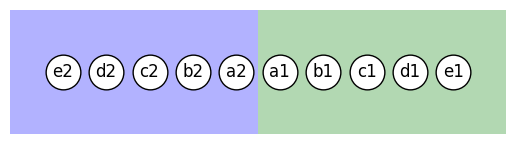

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [171]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

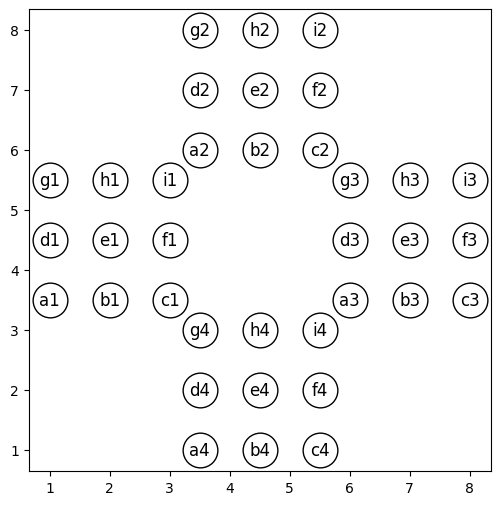

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


In [172]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
#print(df.to_latex())


## Rotating

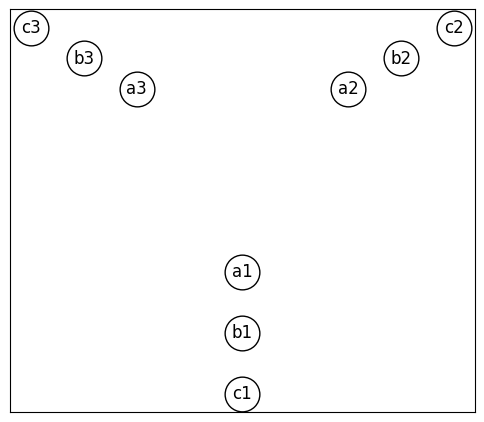

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [173]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

N = len(all_points)
n = 3
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)

result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)
df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
df = df.round(2)  # Rounds all float columns to 2 decimals
display(df)
# print(df.to_latex())

# Simulations

## Methods

In [174]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=n_zones, tolerance=5).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (2, 2)": k_means_samples(coords, probs, n, num_samples, (2, 2)),
        "K-Means (5, 5)": k_means_samples(coords, probs, n, num_samples, (3, 3)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

## Initial Population

In [175]:
n = 4 # Number of item in each sample (number of clusters)
sample_cnt = 20 # How many sample gather from each desiging method

### Coords

Uncomment each one you would like to get result from

In [176]:
######## GRID
n = 10
grid_size = 20
N = grid_size**2
coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
# N = 400
# coords = rng.random_coordinates((N, 2))

######### CLUSTRED
n_clusters = 4
cluster_std = 0.05
N = 400
coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))
idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
N = len(coords)

In [177]:
#list(swiss_df.columns)

### Probabilities

Uncomment each one you would like to get result from

In [178]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
#probs = np.sort(rng.unequal_probabilities(n, N))

probs = inclusion_probabilities(swiss_df['AREA'].to_numpy(), n)

/home/divar/projects/geometric-sampling/.venv/lib/python3.12/site-packages/package_sampling/utils/inclusion_probabilities.py:40: UserWarning: There are zero values in the initial vector `a`.
  warnings.warn("There are zero values in the initial vector `a`.", UserWarning)


## Results

### Plotting coords

/home/divar/projects/geometric-sampling/geometric_sampling/clustering/aggregate.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  ((self.Ti[old_cluster] - self.Ti[new_cluster]) / (2*np.sum(self.X_features[data_index])))
/home/divar/projects/geometric-sampling/geometric_sampling/clustering/aggregate.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  ((self.Ti[old_cluster] - self.goal) / np.sum(self.X_features[data_index])),
/home/divar/projects/geometric-sampling/geometric_sampling/clustering/aggregate.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  ((self.goal - self.Ti[new_cluster]) / np.sum(self.X_features[data_index])),


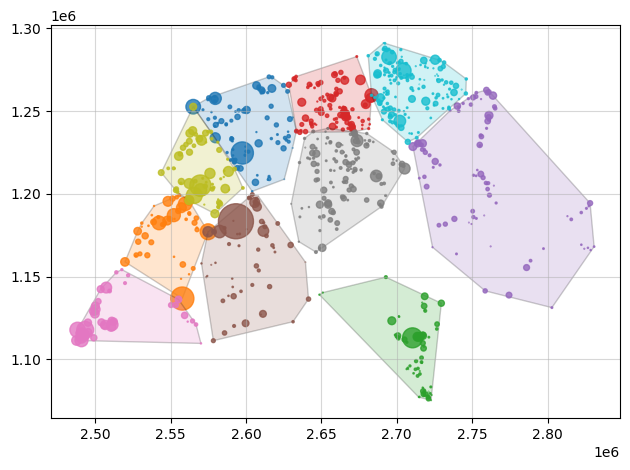

In [179]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

def plot_convex_hull(
        points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
    ):
        if len(points) < 3:
            return ax, None
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
        )
        ax.add_patch(polygon)
        return ax, hull

density_measure = gs.measure.Density(coords, probs, n)
clusters, centroids = density_measure.clusters, density_measure.centroids
fig, ax = plt.subplots()
for cluster_idx, cluster in enumerate(clusters):
    cluster_points = cluster[:, 1:3]
    cluster_color = plt.cm.tab10(cluster_idx % 10)
    cmap = plt.get_cmap('tab10')         # get the colormap object
    n_colors = cmap.N                  # how many entries it has
    cluster_color = cmap(cluster_idx % n_colors)    # 
    ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=cluster_color,
        s=cluster[:, 3] * 1000,
        alpha=0.8,
    )
    ax.grid(alpha=0.5)
    # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()
# ax.show()

### Gathering Data

In [180]:
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

sample_methods = find_samples(coords, probs, n, sample_cnt)

rows = np.array([
    [method, *scores(coords, probs, n, N, s)]
    for method, samples in sample_methods.items()
    for s in tqdm(samples, total=sample_cnt)
])

df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})

/home/divar/projects/geometric-sampling/geometric_sampling/clustering/aggregate.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  ((self.Ti[old_cluster] - self.goal) / np.sum(self.X_features[data_index])),
/home/divar/projects/geometric-sampling/geometric_sampling/clustering/aggregate.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  ((self.goal - self.Ti[new_cluster]) / np.sum(self.X_features[data_index])),
/home/divar/projects/geometric-sampling/geometric_sampling/clustering/aggregate.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  ((self.Ti[old_cluster] - self.Ti[new_cluster]) / (2*np.sum(self.X_features[data_index])))


IndexError: list index out of range

### Tables

Means

In [ ]:
df.groupby("Method").mean()

,Density,Voronoi,Moran,Local Balance
Method,,,,
"K-Means (2, 2)",0.145170,0.238001,-0.100229,0.519991
"K-Means (5, 5)",0.096494,0.156791,-0.136485,0.441119
Local Pivotal,0.201790,0.207218,-0.066837,0.466075
Random,0.261533,0.306894,-0.032674,0.518300
UPmaxentropy,0.264915,0.338522,-0.034082,0.570600


STD

In [ ]:
df.groupby("Method").std()

,Density,Voronoi,Moran,Local Balance
Method,,,,
"K-Means (2, 2)",0.112432,0.156622,0.036572,0.180212
"K-Means (5, 5)",0.070767,0.094630,0.045756,0.120641
Local Pivotal,0.075878,0.158979,0.033140,0.149700
Random,0.112299,0.266243,0.053732,0.153281
UPmaxentropy,0.123190,0.271665,0.045676,0.177404


Describe

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (2, 2)    20.0  0.145170  0.112432  0.029234  0.067156  0.100633   
K-Means (5, 5)    20.0  0.096494  0.070767  0.013362  0.049666  0.063790   
Local Pivotal     20.0  0.201790  0.075878  0.049585  0.155636  0.184619   
Random            20.0  0.261533  0.112299  0.062228  0.189190  0.278931   
UPmaxentropy      20.0  0.264915  0.123190  0.052559  0.193073  0.244701   

                                   Voronoi                                \
                     75%       max   count      mean       std       min   
Method                                                                     
K-Means (2, 2)  0.192593  0.360823    20.0  0.238001  0.156622  0.055231   
K-Means (5, 5)  0.128615  0.235211    20.0  0.156791  0.094630  0.024420   
Local Pivotal   0.240391  0.389019    20.0  0.207218  0.158979  0.019993   
Random          0.336320  0.445747    20.0  0.306894  0.266243  0.037903   
UPmaxentropy    0.320214  0.583671    20.0  0.338522  0.271665  0.046619   

                                                       Moran            \
                     25%       50%       75%       max count      mean   
Method                                                                   
K-Means (2, 2)  0.137531  0.176738  0.330731  0.585389  20.0 -0.100229   
K-Means (5, 5)  0.089476  0.148476  0.204666  0.405231  20.0 -0.136485   
Local Pivotal   0.122959  0.173085  0.222274  0.718244  20.0 -0.066837   
Random          0.116505  0.251547  0.437346  0.958649  20.0 -0.032674   
UPmaxentropy    0.167814  0.245245  0.445908  1.117304  20.0 -0.034082   

                                                                            \
                     std       min       25%       50%       75%       max   
Method                                                                       
K-Means (2, 2)  0.036572 -0.176617 -0.119633 -0.102011 -0.073436 -0.038063   
K-Means (5, 5)  0.045756 -0.204532 -0.180570 -0.134384 -0.096229 -0.058274   
Local Pivotal   0.033140 -0.149471 -0.094040 -0.062273 -0.046070 -0.006975   
Random          0.053732 -0.143415 -0.068111 -0.043304  0.017122  0.040603   
UPmaxentropy    0.045676 -0.124192 -0.056053 -0.032463 -0.020621  0.081287   

               Local Balance                                          \
                       count      mean       std       min       25%   
Method                                                                 
K-Means (2, 2)          20.0  0.519991  0.180212  0.277224  0.394608   
K-Means (5, 5)          20.0  0.441119  0.120641  0.232629  0.384237   
Local Pivotal           20.0  0.466075  0.149700  0.246237  0.361917   
Random                  20.0  0.518300  0.153281  0.244660  0.437273   
UPmaxentropy            20.0  0.570600  0.177404  0.303375  0.459037   

                                              
                     50%       75%       max  
Method                                        
K-Means (2, 2)  0.450575  0.706861  0.871239  
K-Means (5, 5)  0.449852  0.478968  0.685785  
Local Pivotal   0.411056  0.535127  0.806420  
Random          0.522521  0.619971  0.772200  
UPmaxentropy    0.518191  0.660724  1.022254

### Plots

##### Color Pallet

In [ ]:
methods = df["Method"].unique()
method_palette = dict(zip(methods, sns.color_palette("Pastel1", n_colors=len(methods))))

##### Boxplot

In [ ]:
def remove_outliers(dataframe, column, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]

        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return dataframe[(df[column] >= lower) & (dataframe[column] <= upper)]

    return df

/tmp/ipykernel_63805/229233119.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_63805/229233119.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_63805/229233119.py:11: DeprecationWarning: DataFrameGroupBy.apply opera

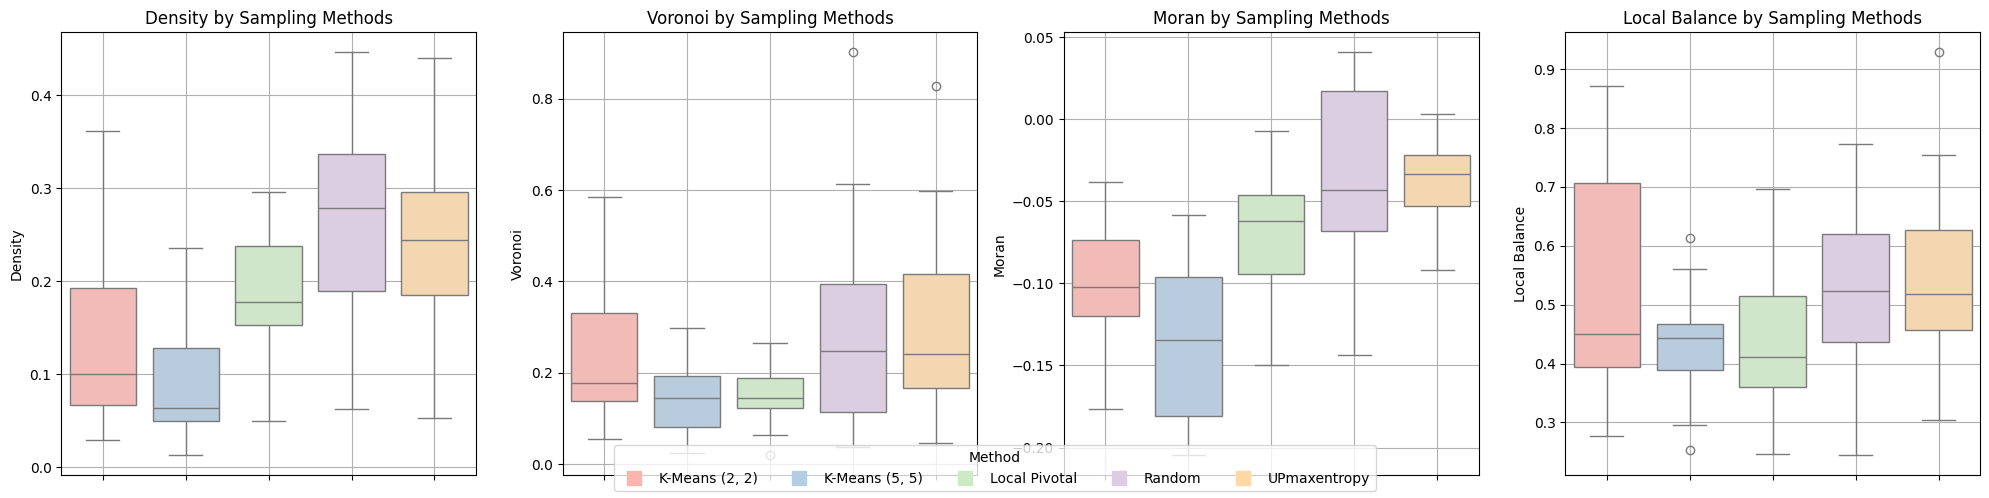

In [ ]:
number_of_items = len(columns[1:])
n_cols = 4  # how many plots per row
n_rows = (number_of_items + n_cols - 1) // n_cols  # compute needed rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

axes = axes.flatten()

for idx, column in enumerate(columns[1:]):
    sns.boxplot(x="Method", y=column, data=remove_outliers(df, column, groupby_col="Method"), hue="Method", palette=method_palette, ax=axes[idx])
    axes[idx].set_title(f'{column} by Sampling Methods')
    axes[idx].set_xlabel("")
    axes[idx].set_xticklabels([])
    axes[idx].grid(True)

handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, label=method) for method, color in method_palette.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(methods), fontsize=10, title="Method")

fig.tight_layout()
plt.show()